In [21]:
import numpy as np
import scipy as sp
from scipy.linalg import eigh
from scipy.sparse.linalg import LinearOperator, eigsh
import matplotlib.pyplot as plt

## Part A: transverse Ising model $(J, h)$ phase diagram (without symmetries)

First, let us form the many-body Hamiltonian of the form ($J = 1$, periodic BC):
$$H = \sum\limits_{i=0}^{N - 1} \sigma_i^z \sigma_{i + 1}^z + h \sum\limits_i \sigma^x.$$

First, please construct the first term:

In [22]:
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.diag([1, -1])
sigma_0 = np.eye(2)
N = 8 # the number of spins in the system

def fill_identities(h_local, begin, end):
    # fill the sites to the left of the local Hamiltonian (h_local) with identities
    # hint: take care to consider the boundary terms separately
    # note I: begin and end are site indices
    # note II: make sure to return the result of multiplying (by tensor product) the identities with h_local to the LEFT of h_local
    left = [sigma_0] * begin
    right = [sigma_0] * (N - end - 1)
    individual_matrices = left + [h_local] + right
    #print(individual_matrices)
    tensorial_result = individual_matrices[0]
    for i in range(1, len(individual_matrices)):
        tensorial_result = np.kron(tensorial_result, individual_matrices[i])
    #print(tensorial_result.shape)
    return tensorial_result


def hamiltonian_j(N):
    # sigma_z term of the Hamiltonian
    H = np.zeros((2 ** N, 2 ** N), dtype=np.complex128)  # shape of the full many-body N-spins hamiltonian
    for i in range(N - 1):  # loop over all spins except the boundary pair
        # fill sites i and i+1 with sigma_z
        h_local = np.kron(sigma_z, sigma_z)
        # fill the rest of the sites with identities
        term = fill_identities(h_local, i, i + 1)
        H += term
    # construct the boundary term separately
    h_boundary = np.kron(sigma_z, sigma_z)
    H += fill_identities(h_boundary, 0, 1)
    H += fill_identities(h_boundary, N-2, N-1)

    return H.real
    
    

In [23]:
print(np.kron(sigma_x, sigma_0))

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


Then please construct the transverse field term with $h = 1$:

In [24]:
def hamiltonian_h(N):
    # the sigma_x term of the Hamiltonian
    H = np.zeros((2 ** N, 2 ** N), dtype=np.complex128)  # shape of the full many-body N-spins hamiltonian
    for i in range(N):
        # fill site i with sigma_x)
        # fill the rest of the sites with identities
        H += fill_identities(sigma_x, i, i)

    return H.real

In [25]:
H_j = hamiltonian_j(N)  # obtain the j-part (remains unchanged)
H_h = hamiltonian_h(N)  # obtain normalized h--part

Now obtain the low-energy spectrum of the model:

In [26]:
# obtain the low-energy spectrum of the model
n_low_levels = 10
h_vals = np.linspace(-2, 2, 40)
levels = []

for h in h_vals:
    # construct the total Hamiltonian
    H = H_j + h * H_h
    # obtain the eigenvalues
    eigenvalues = eigh(H)
    # append the `n_low_levels` lowest eigenvalues to levels
    levels += [eigenvalues[0][:n_low_levels]]

levels = np.array(levels)

Plot the obtained energy spectrum as a function of $h / J$:

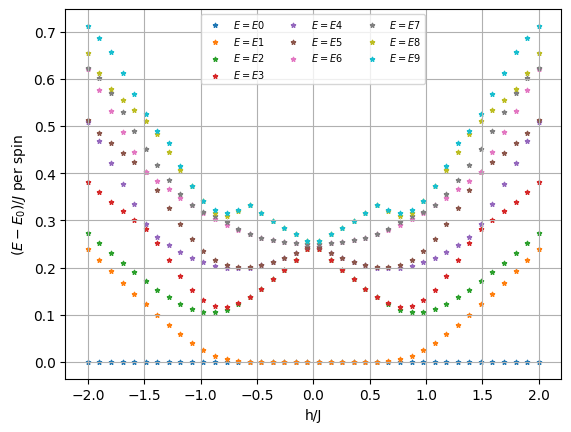

In [32]:
for level in range(n_low_levels):
    plt.scatter(h_vals, levels[:, level] / N - levels[:, 0] / N, marker='*', s = 10.,label='$E = E%s$' % (level))

plt.legend(fontsize=7,ncol=3)
plt.grid(True)
plt.xlabel('h/J')
plt.ylabel('$(E - E_0) / J$ per spin')
plt.show()

As $|h| < J$, the system is in the antiferromagnetic phase, the lowest two states with momenta $k = 0$ and $k = \pi$ are degenerate (you can check this by expressing the Hamiltonian in the basis of eigenstates of the translation operator $\hat{T}$ and diagonalizing it in this basis). At $|h| > J$ the system undergoes a phase transition to the paramagnetic phase, where this degeneracy is broken.

## Part B

Instead of constructing a dense matrix, you can also use the bit representation to implement the action of the Hamiltonian in terms of bitwise operations. This function can be used as a scipy linear operator in the Lanczos eigenvalue solver. This procedure is particularly useful for larger problems.

To employ the bitstring represenation: the basis element number $k$ should be written in the binary representation to get the individual spin orientations. For instance, the basis element $k = 415 = 256 + 128 + 16 + 8 + 4 + 2 + 1$ with $N = 10$ spins would correspond to the bitstring (0, 1, 1, 0, 0, 1, 1, 1, 1, 1), meaning, 0-th, 3-rd and 4-th spins are down, others up.

We reuse our the code from last week for computations on binary strings:

In [33]:
def shift_right(spins: int, shift: int, N: int) -> int:
    for j in range(0,shift):
        spins = (spins>>1) + 2**(N-1)*(spins%2)
    return spins

def shift_left(spins:int, shift:int, N:int) -> int:
    for j in range(0, shift):
        if spins >= 2**(N-1):
            spins = (spins<<1) - (2**(N)) +1
        else:
            spins = spins<<1
    return spins

def count_upspins(i:int) -> int:
    return format(i,'b').count('1')

def spin_at_j(i: int, j: int) -> int:
    return (i>>j)%2

def flip_spin(i: int, j: int) -> int:
    return (1<<j)^i

def flip_all_spins(i: int, N: int) -> int:
    return i^(2**N-1)

Then, we can construct the action of the Hamiltonian on the states as bitwise operations. To implement the action of the Hamiltonian as a Scipy Linear Operator, we want to define the operation $\vec{y}=H\vec{x}$.

To this end, note that the wavefunction is written as $|\psi\rangle=\sum_{i=0}^{2^N-1} x[i]|i\rangle$, where $|i\rangle$ is the index corresponding to a spin configuration and $x[i]$ is the corresponding weight. Since the $\sigma_z$ term in the Hamiltonian is diagonal, we have $y[i]=E_z(i)x[i]$ under the action of this term, where $E_z(i)$ is the eigenvalue of the diagonal term associated with state $|i\rangle$. The $h$ (i.e. $\sigma_x$) term has matrix elements between the different indices, so we have $y[i]=H_{ij}x[j]$.


In [ ]:
def act_hz(x):
    y = np.zeros(2 ** N)
    for spins in range(2**N):
        spin_interaction = spins ^ shift_left(spins, 1, N)
        E_z = spin_interaction - (N-spin_interaction)
        # implement the action of Hz
        # hint: the bit shift "<<" and the XOR "^" operations are useful here!
        y[spins] = E_z*x[spins]
        # y[spins] = ...

    return y

#NÖÖÖÖÖÖÖÖÖÖDDD SIIICHER

In [35]:
def act_h(x, h):
    y = np.zeros(2 ** N)
    for spins in range(2 ** N):
        # implement the action of Hx
        for k in range(N):
            spins_interacttion = spins ^ shift_left(spins, k, N)
            spin_energy = count_upspins(spins_interacttion)
            E_x = spin_energy - (N - spin_energy)
            y[spins] +=E_x * x[spins]
        # you'll need to flip a single spin at site s and sum them up
        # hint: the bit shift "<<" and the XOR "^" operations are useful here!

    return h * y

Now we're in a good position to implement the Lanczos algorithm -- does this give the same result as Part A?

In [40]:
n_low_levels = 10
h_vals = np.linspace(-2, 2, 40)
levels = []

for h in h_vals:
    def act_H(vec):
        return act_hz(vec) + act_h(vec, h)
    H = LinearOperator((2**N, 2**N), matvec=lambda vec: act_H(vec), dtype=np.complex128)
    eigenvalues, _ = eigsh(H, k=n_low_levels + 1, which='SA')
    levels.append(eigenvalues[:n_low_levels])

    # construct the Linear Operator corresponding to act_H
    # obtain the n_low_levels lowest eigenvalues from Lanczos, append to levels
    # word of caution: obtain more eigenvalues than needed from Lanczos to avoid convergence issues

levels = np.array(levels)

/var/folders/x0/zx3zh2g96tvbvblvgctx16n00000gn/T/ipykernel_14874/1823616206.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  y[spins] += E_z*x[spins]
/var/folders/x0/zx3zh2g96tvbvblvgctx16n00000gn/T/ipykernel_14874/889470843.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  y[spins] +=E_x * x[spins]


KeyboardInterrupt: 

In [ ]:
for level in range(n_low_levels):
    plt.scatter(h_vals, levels[:, level] / N - levels[:, 0] / N, marker='*', s = 10.,label='$E = E%s$' % (level))

plt.legend(fontsize=7,ncol=3)
plt.grid(True)
plt.xlabel('h/J')
plt.ylabel('$(E - E_0) / J$ per spin')
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## Part C

The transverse field Ising Hamiltonian has many symmetries. Finding the symmetry essentially means finding another basis where the hamiltonian takes the _block-diagonal form_. Among the possible symmetries, there are:

1) Flipping all spins with the operator $X = \otimes_i \sigma_i^x$,

2) Total magnetisation conservation with the operator $M = \sum\limits_i \sigma_i^z$ (only at $h = 0$)

3) Translation symmetry $T: i \to i + 1\,\text{mod N}$ with a rather non-local operator form.

If the Hamiltonian has a symmetry $[H, A] = 0$ (block-diagonal form in some basis), $H$ and $A$ can be diagonalized simultaneously. This means that the Hamiltonian does not mix the eigenstates from sectors with different eigenvalues of $A$. This fact allows one to search for $H$ eigenstates in the sectors of $A$ eigenvalues one-by-one, which might significantly reduce the ED-complexity.

At the end of this first exercise, please constuct the operators for the symmetries (1) and (2) and explicitly check that $[\hat H, \hat A] = 0$ for both of them.

We start with the flipping symmetry:

In [ ]:
A = np.eye(1)
H = H_j + H_h * np.random.uniform(-2, 2)  # hamiltonian with arbitrary value of field h

# construct the A--operator

assert np.allclose(H.dot(A), A.dot(H))

We proceed with the total magnetisation operator M, which is the symmetry only for $h = 0$:

In [ ]:
M = np.zeros((2 ** N, 2 ** N))
H = H_j + H_h * np.random.uniform(-1, 1)  # hamiltonian with arbitrary value of field h

# construct the M--operator

assert not np.allclose(H.dot(M), M.dot(H))
assert np.allclose(H_j.dot(M), M.dot(H_j))